In [122]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [123]:
data = pd.read_csv('diabetes.csv')
# Nowy plik, bo KNN mocno mieli, więc wolę testować osobno puszczając cały plik

In [124]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [125]:
data = data[data['Glucose'] != 0]
data = data[data['BloodPressure'] != 0]
data = data[data['SkinThickness'] != 0]
data = data[data['Insulin'] != 0]
data = data[data['BMI'] != 0]
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [126]:
# Klasa statyczna zawierająca metody przydatne to przetwarzania danych
class ProcessingData:

    # metoda tasująca wiersze pd.DataFrame
    @staticmethod
    def shuffle(df: pd.DataFrame) -> pd.DataFrame:
        """
        Receives a DataFrame, randomly shuffles it and returns a shuffled version.
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        for idx in range(len(df) - 1, 0, -1):
            rand_idx = random.randint(0, idx)
            df.iloc[idx], df.iloc[rand_idx] = df.iloc[rand_idx], df.iloc[idx]
        return df.reset_index(drop=True)

    # metoda normalizująca kolumny pd.DataFrame za pomocą normalizacji z użyciem odchylenia standardowego
    @staticmethod
    def normalize_std(df: pd.DataFrame, label: str) -> pd.DataFrame:
        """
        Receives a DataFrame and a class label to skip during normalization, normalizes data using min-max normalization and returns the normalized version.
        :param label: str
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        normalized = df.drop(labels=label, axis=1)
        normalized = (normalized-normalized.mean())/(normalized.std())
        return normalized.join(df[label])

    # metoda normalizująca kolumny pd.DataFrame za pomocą normalizacji minmax
    @staticmethod
    def normalize_minmax(df: pd.DataFrame, label: str) -> pd.DataFrame:
        """
        Receives a DataFrame and a class label to skip during normalization, normalizes data using min-max normalization and returns the normalized version.
        :param label: str
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        normalized = df.drop(labels=label, axis=1)
        normalized = (normalized-normalized.min())/(normalized.max()-normalized.min())
        return normalized.join(df[label])

    # metoda dzieląca pd.DataFrame na zbiór treningowy oraz walidacyjny
    @staticmethod
    def split(df: pd.DataFrame, ratio: float) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Receives a DataFrame and returns two dataframes, split into training and validation DataFrames.
        :param df: pd.DataFrame
        :param ratio: float
        :return training_df, validation_df: tuple[pd.DataFrame, pd.DataFrame]
        """
        cutoff = int(len(df) * ratio)
        return df[:cutoff].reset_index(drop=True), df[cutoff:].reset_index(drop=True)

In [127]:
shuffled_data = ProcessingData.shuffle(data)
training_data, _ = ProcessingData.split(shuffled_data, 0.7)

In [128]:
# Klasyfikator zbiorów rozmytych
"""
Normy:
Pregnancies:
-
Glucose:
- 70-99 prawidlowe
- 100-125 ryzyko
- 126+ cukrzyca
BloodPressure:
- <80 prawidlowe
- 80-89 podwyzszone faza 1
- >90 podwyszone faza 2
SkinThickness:
- mediana 25 mm
Insulin:
- <30
Age:
- ryzyko od 45 r.ż.
BMI:
- 18.5 - 24.9 waga prawidłowa
- 25.0 - 29.9 nadwaga
- >30 otyłość
DiabetesPedigreeFunction
-
"""

'\nNormy:\nPregnancies:\n-\nGlucose:\n- 70-99 prawidlowe\n- 100-125 ryzyko\n- 126+ cukrzyca\nBloodPressure:\n- <80 prawidlowe\n- 80-89 podwyzszone faza 1\n- >90 podwyszone faza 2\nSkinThickness:\n- mediana 25 mm\nInsulin:\n- <30\nAge:\n- ryzyko od 45 r.ż.\nBMI:\n- 18.5 - 24.9 waga prawidłowa\n- 25.0 - 29.9 nadwaga\n- >30 otyłość\nDiabetesPedigreeFunction\n-\n'

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    274.000000
mean       3.452555
std        3.304943
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       17.000000
Name: Pregnancies, dtype: float64

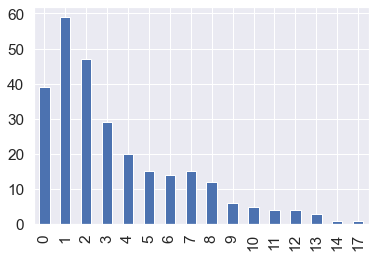

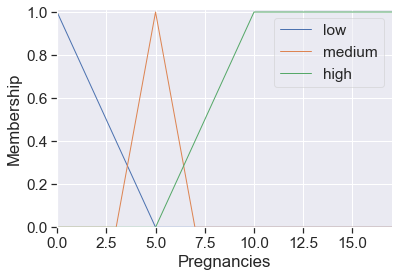

In [129]:
pregnancies_data = training_data['Pregnancies']
pregnancies_data.value_counts().sort_index().plot.bar(sort_columns=True)
pregnancies = ctrl.Antecedent(pregnancies_data.sort_values(), 'Pregnancies')
pregnancies['low'] = fuzz.trimf(pregnancies.universe, [0, 0, 5])
pregnancies['medium'] = fuzz.trimf(pregnancies.universe, [3, 5, 7])
pregnancies['high'] = fuzz.trapmf(pregnancies.universe, [5, 10, 17, 17])
pregnancies.view()
pregnancies_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    274.000000
mean     126.065693
std       31.271517
min       56.000000
25%      100.250000
50%      123.000000
75%      146.750000
max      198.000000
Name: Glucose, dtype: float64

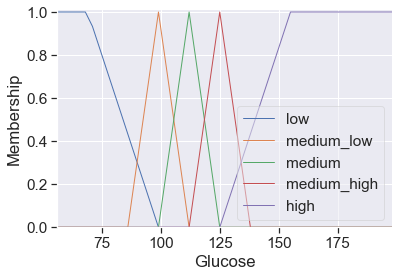

In [130]:
glucose_data = training_data['Glucose']
glucose_data = glucose_data[glucose_data != 0]
glucose = ctrl.Antecedent(glucose_data.sort_values(), 'Glucose')
glucose['low'] = fuzz.trapmf(glucose.universe, [44, 44, 69, 99])
glucose['medium_low'] = fuzz.trimf(glucose.universe, [86, 99, 112])
glucose['medium'] = fuzz.trimf(glucose.universe, [99, 112, 125])
glucose['medium_high'] = fuzz.trimf(glucose.universe, [112, 125, 138])
glucose['high'] = fuzz.trapmf(glucose.universe, [125, 155, 199, 199])
glucose.view()
glucose_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    274.000000
mean      71.160584
std       12.334907
min       24.000000
25%       64.000000
50%       71.000000
75%       78.000000
max      110.000000
Name: BloodPressure, dtype: float64

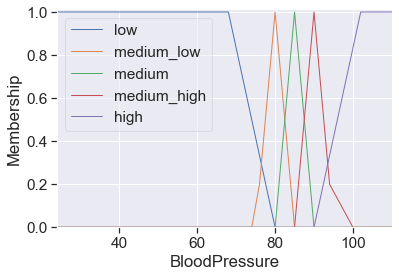

In [131]:
bloodpressure_data = training_data['BloodPressure']
bloodpressure_data = bloodpressure_data[bloodpressure_data != 0]
bloodpressure = ctrl.Antecedent(bloodpressure_data.sort_values(), 'BloodPressure')
bloodpressure['low'] = fuzz.trapmf(bloodpressure.universe, [24, 24, 68, 80])
bloodpressure['medium_low'] = fuzz.trimf(bloodpressure.universe, [75, 80, 85])
bloodpressure['medium'] = fuzz.trimf(bloodpressure.universe, [80, 85, 90])
bloodpressure['medium_high'] = fuzz.trimf(bloodpressure.universe, [85, 90, 95])
bloodpressure['high'] = fuzz.trapmf(bloodpressure.universe, [90, 102, 122, 122])
bloodpressure.view()
bloodpressure_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    274.000000
mean      29.810219
std       10.471334
min        8.000000
25%       22.000000
50%       30.000000
75%       37.000000
max       63.000000
Name: SkinThickness, dtype: float64

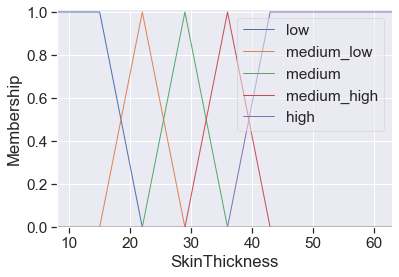

In [132]:
skinthickness_data = training_data['SkinThickness']
skinthickness_data = skinthickness_data[skinthickness_data != 0]
skinthickness = ctrl.Antecedent(skinthickness_data.sort_values(), 'SkinThickness')
skinthickness['low'] = fuzz.trapmf(skinthickness.universe, [7, 7, 15, 22])
skinthickness['medium_low'] = fuzz.trimf(skinthickness.universe, [15, 22, 29])
skinthickness['medium'] = fuzz.trimf(skinthickness.universe, [22, 29, 36])
skinthickness['medium_high'] = fuzz.trimf(skinthickness.universe, [29, 36, 43])
skinthickness['high'] = fuzz.trapmf(skinthickness.universe, [36, 43, 99, 99])
skinthickness.view()
skinthickness_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    274.000000
mean     158.536496
std      114.972877
min       14.000000
25%       82.000000
50%      129.500000
75%      192.250000
max      744.000000
Name: Insulin, dtype: float64

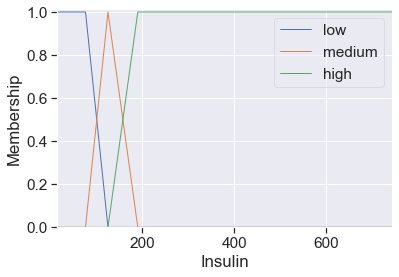

In [133]:
insulin_data = training_data['Insulin']
insulin_data = insulin_data[insulin_data != 0]
insulin = ctrl.Antecedent(insulin_data.sort_values(), 'Insulin')
insulin['low'] = fuzz.trapmf(insulin.universe, [14, 14, 76, 125])
insulin['medium'] = fuzz.trimf(insulin.universe, [76, 125, 190])
insulin['high'] = fuzz.trapmf(insulin.universe, [125, 190, 846, 846])
insulin.view()
insulin_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    274.000000
mean      33.221168
std        7.024347
min       18.200000
25%       28.425000
50%       33.200000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

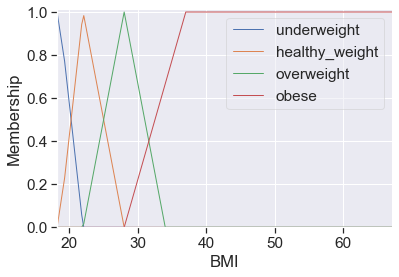

In [134]:
bmi_data = training_data['BMI']
bmi_data = bmi_data[bmi_data != 0]
bmi = ctrl.Antecedent(bmi_data.sort_values(), 'BMI')
bmi['underweight'] = fuzz.trapmf(bmi.universe, [0, 0, 18.5, 22])
bmi['healthy_weight'] = fuzz.trimf(bmi.universe, [18.5, 22, 28])
bmi['overweight'] = fuzz.trimf(bmi.universe, [22, 28, 34])
bmi['obese'] = fuzz.trapmf(bmi.universe, [28, 37, 67.1, 67.1])
bmi.view()
bmi_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    274.000000
mean       0.528843
std        0.346464
min        0.085000
25%        0.282500
50%        0.463500
75%        0.692000
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64

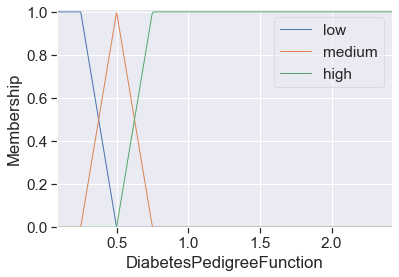

In [135]:
diabetespedigreefunction_data = training_data['DiabetesPedigreeFunction']
diabetespedigreefunction_data = diabetespedigreefunction_data[diabetespedigreefunction_data != 0]
diabetespedigreefunction = ctrl.Antecedent(diabetespedigreefunction_data.sort_values(), 'DiabetesPedigreeFunction')
diabetespedigreefunction['low'] = fuzz.trapmf(diabetespedigreefunction.universe, [0, 0, 0.25, 0.5])
diabetespedigreefunction['medium'] = fuzz.trimf(diabetespedigreefunction.universe, [0.25, 0.5, 0.75])
diabetespedigreefunction['high'] = fuzz.trapmf(diabetespedigreefunction.universe, [0.5, 0.75, 2.42, 2.42])
diabetespedigreefunction.view()
diabetespedigreefunction_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    274.000000
mean      30.956204
std       10.118976
min       21.000000
25%       23.000000
50%       27.000000
75%       36.000000
max       81.000000
Name: Age, dtype: float64

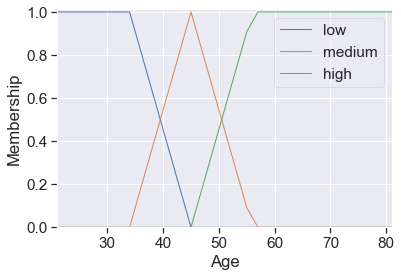

In [136]:
age_data = training_data['Age']
age_data = age_data[age_data != 0]
age = ctrl.Antecedent(age_data.sort_values(), 'Age')
age['low'] = fuzz.trapmf(age.universe, [21, 21, 34, 45])
age['medium'] = fuzz.trimf(age.universe, [34, 45, 56])
age['high'] = fuzz.trapmf(age.universe, [45, 56, 81, 81])
age.view()
age_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


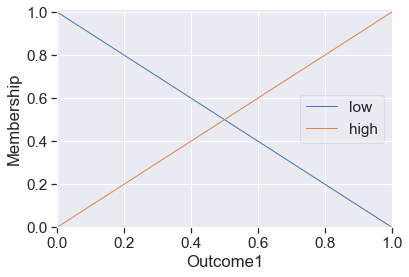

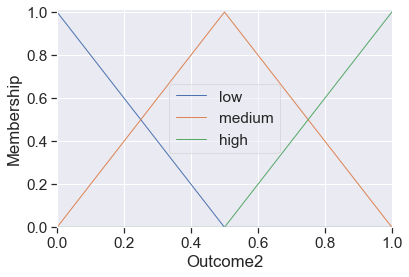

In [137]:
outcome1 = ctrl.Consequent(np.linspace(0., 1., num=1001), 'Outcome1')
outcome1['low'] = fuzz.trimf(outcome1.universe, [0, 0, 1])
outcome1['high'] = fuzz.trimf(outcome1.universe, [0, 1, 1])
outcome1.view()

outcome2 = ctrl.Consequent(np.linspace(0., 1., num=1001), 'Outcome2')
outcome2['low'] = fuzz.trimf(outcome2.universe, [0, 0, 0.5])
outcome2['medium'] = fuzz.trimf(outcome2.universe, [0, 0.5, 1])
outcome2['high'] = fuzz.trimf(outcome2.universe, [0.5, 1, 1])
outcome2.view()

In [138]:
# Zasady dla Outcome bez przypadków połowicznych

# Zasady dla pregnancies['low'] - 17 17
rule100 = ctrl.Rule(pregnancies['low'] & glucose['low'], outcome1['low'])
rule101 = ctrl.Rule(pregnancies['low'] & glucose['medium_low'], outcome1['low'])
rule102 = ctrl.Rule(pregnancies['low'] & glucose['medium'], outcome1['low'])
# rule103 = ctrl.Rule(pregnancies['low'] & bloodpressure['low'], outcome1['low'])
# rule104 = ctrl.Rule(pregnancies['low'] & bloodpressure['medium_low'], outcome1['low'])
# rule105 = ctrl.Rule(pregnancies['low'] & bloodpressure['medium'], outcome1['low'])
rule106 = ctrl.Rule(pregnancies['low'] & skinthickness['low'], outcome1['low'])
rule107 = ctrl.Rule(pregnancies['low'] & skinthickness['medium_low'], outcome1['low'])
rule108 = ctrl.Rule(pregnancies['low'] & skinthickness['medium'], outcome1['low'])
rule109 = ctrl.Rule(pregnancies['low'] & insulin['low'], outcome1['low'])
rule110 = ctrl.Rule(pregnancies['low'] & insulin['medium'], outcome1['low'])
rule111 = ctrl.Rule(pregnancies['low'] & bmi['underweight'], outcome1['low'])
rule112 = ctrl.Rule(pregnancies['low'] & bmi['healthy_weight'], outcome1['low'])
rule113 = ctrl.Rule(pregnancies['low'] & diabetespedigreefunction['low'], outcome1['low'])
rule114 = ctrl.Rule(pregnancies['low'] & diabetespedigreefunction['medium'], outcome1['low'])
rule115 = ctrl.Rule(pregnancies['low'] & age['low'], outcome1['low'])
rule116 = ctrl.Rule(pregnancies['low'] & age['medium'], outcome1['low'])

# Zasady dla glucose['low'] - 15 32
rule120 = ctrl.Rule(glucose['low'] & pregnancies['medium'], outcome1['low'])
# rule121 = ctrl.Rule(glucose['low'] & bloodpressure['low'], outcome1['low'])
# rule122 = ctrl.Rule(glucose['low'] & bloodpressure['medium_low'], outcome1['low'])
# rule123 = ctrl.Rule(glucose['low'] & bloodpressure['medium'], outcome1['low'])
rule124 = ctrl.Rule(glucose['low'] & skinthickness['low'], outcome1['low'])
rule125 = ctrl.Rule(glucose['low'] & skinthickness['medium_low'], outcome1['low'])
rule126 = ctrl.Rule(glucose['low'] & skinthickness['medium'], outcome1['low'])
rule127 = ctrl.Rule(glucose['low'] & insulin['low'], outcome1['low'])
rule128 = ctrl.Rule(glucose['low'] & insulin['medium'], outcome1['low'])
rule129 = ctrl.Rule(glucose['low'] & bmi['underweight'], outcome1['low'])
rule130 = ctrl.Rule(glucose['low'] & bmi['healthy_weight'], outcome1['low'])
rule131 = ctrl.Rule(glucose['low'] & diabetespedigreefunction['low'], outcome1['low'])
rule132 = ctrl.Rule(glucose['low'] & diabetespedigreefunction['medium'], outcome1['low'])
rule133 = ctrl.Rule(glucose['low'] & age['low'], outcome1['low'])
rule134 = ctrl.Rule(glucose['low'] & age['medium'], outcome1['low'])

# Zasady dla glucose['medium_low'] - 15 47
rule140 = ctrl.Rule(glucose['medium_low'] & pregnancies['medium'], outcome1['low'])
# rule141 = ctrl.Rule(glucose['medium_low'] & bloodpressure['low'], outcome1['low'])
# rule142 = ctrl.Rule(glucose['medium_low'] & bloodpressure['medium_low'], outcome1['low'])
# rule143 = ctrl.Rule(glucose['medium_low'] & bloodpressure['medium'], outcome1['low'])
rule144 = ctrl.Rule(glucose['medium_low'] & skinthickness['low'], outcome1['low'])
rule145 = ctrl.Rule(glucose['medium_low'] & skinthickness['medium_low'], outcome1['low'])
rule146 = ctrl.Rule(glucose['medium_low'] & skinthickness['medium'], outcome1['low'])
rule147 = ctrl.Rule(glucose['medium_low'] & insulin['low'], outcome1['low'])
rule148 = ctrl.Rule(glucose['medium_low'] & insulin['medium'], outcome1['low'])
rule149 = ctrl.Rule(glucose['medium_low'] & bmi['underweight'], outcome1['low'])
rule150 = ctrl.Rule(glucose['medium_low'] & bmi['healthy_weight'], outcome1['low'])
rule151 = ctrl.Rule(glucose['medium_low'] & diabetespedigreefunction['low'], outcome1['low'])
rule152 = ctrl.Rule(glucose['medium_low'] & diabetespedigreefunction['medium'], outcome1['low'])
rule153 = ctrl.Rule(glucose['medium_low'] & age['low'], outcome1['low'])
rule154 = ctrl.Rule(glucose['medium_low'] & age['medium'], outcome1['low'])

# # Zasady dla bloodpressure['low'] - 13 60
# rule160 = ctrl.Rule(bloodpressure['low'] & pregnancies['medium'], outcome1['low'])
# rule161 = ctrl.Rule(bloodpressure['low'] & glucose['medium'], outcome1['low'])
# rule162 = ctrl.Rule(bloodpressure['low'] & skinthickness['low'], outcome1['low'])
# rule163 = ctrl.Rule(bloodpressure['low'] & skinthickness['medium_low'], outcome1['low'])
# rule164 = ctrl.Rule(bloodpressure['low'] & skinthickness['medium'], outcome1['low'])
# rule165 = ctrl.Rule(bloodpressure['low'] & insulin['low'], outcome1['low'])
# rule166 = ctrl.Rule(bloodpressure['low'] & insulin['medium'], outcome1['low'])
# rule167 = ctrl.Rule(bloodpressure['low'] & bmi['underweight'], outcome1['low'])
# rule168 = ctrl.Rule(bloodpressure['low'] & bmi['healthy_weight'], outcome1['low'])
# rule169 = ctrl.Rule(bloodpressure['low'] & diabetespedigreefunction['low'], outcome1['low'])
# rule170 = ctrl.Rule(bloodpressure['low'] & diabetespedigreefunction['medium'], outcome1['low'])
# rule171 = ctrl.Rule(bloodpressure['low'] & age['low'], outcome1['low'])
# rule172 = ctrl.Rule(bloodpressure['low'] & age['medium'], outcome1['low'])

# # Zasady dla bloodpressure['medium_low'] - 13 73
# rule180 = ctrl.Rule(bloodpressure['medium_low'] & pregnancies['medium'], outcome1['low'])
# rule181 = ctrl.Rule(bloodpressure['medium_low'] & glucose['medium'], outcome1['low'])
# rule182 = ctrl.Rule(bloodpressure['medium_low'] & skinthickness['low'], outcome1['low'])
# rule183 = ctrl.Rule(bloodpressure['medium_low'] & skinthickness['medium_low'], outcome1['low'])
# rule184 = ctrl.Rule(bloodpressure['medium_low'] & skinthickness['medium'], outcome1['low'])
# rule185 = ctrl.Rule(bloodpressure['medium_low'] & insulin['low'], outcome1['low'])
# rule186 = ctrl.Rule(bloodpressure['medium_low'] & insulin['medium'], outcome1['low'])
# rule187 = ctrl.Rule(bloodpressure['medium_low'] & bmi['underweight'], outcome1['low'])
# rule188 = ctrl.Rule(bloodpressure['medium_low'] & bmi['healthy_weight'], outcome1['low'])
# rule189 = ctrl.Rule(bloodpressure['medium_low'] & diabetespedigreefunction['low'], outcome1['low'])
# rule190 = ctrl.Rule(bloodpressure['medium_low'] & diabetespedigreefunction['medium'], outcome1['low'])
# rule191 = ctrl.Rule(bloodpressure['medium_low'] & age['low'], outcome1['low'])
# rule192 = ctrl.Rule(bloodpressure['medium_low'] & age['medium'], outcome1['low'])

# Zasady dla skinthickness['low'] - 11 84
rule200 = ctrl.Rule(skinthickness['low'] & pregnancies['medium'], outcome1['low'])
rule201 = ctrl.Rule(skinthickness['low'] & glucose['medium'], outcome1['low'])
# rule202 = ctrl.Rule(skinthickness['low'] & bloodpressure['medium'], outcome1['low'])
rule203 = ctrl.Rule(skinthickness['low'] & insulin['low'], outcome1['low'])
rule204 = ctrl.Rule(skinthickness['low'] & insulin['medium'], outcome1['low'])
rule205 = ctrl.Rule(skinthickness['low'] & bmi['underweight'], outcome1['low'])
rule206 = ctrl.Rule(skinthickness['low'] & bmi['healthy_weight'], outcome1['low'])
rule207 = ctrl.Rule(skinthickness['low'] & diabetespedigreefunction['low'], outcome1['low'])
rule208 = ctrl.Rule(skinthickness['low'] & diabetespedigreefunction['medium'], outcome1['low'])
rule209 = ctrl.Rule(skinthickness['low'] & age['low'], outcome1['low'])
rule210 = ctrl.Rule(skinthickness['low'] & age['medium'], outcome1['low'])

# Zasady dla skinthickness['medium_low'] - 11 95
rule220 = ctrl.Rule(skinthickness['medium_low'] & pregnancies['medium'], outcome1['low'])
rule221 = ctrl.Rule(skinthickness['medium_low'] & glucose['medium'], outcome1['low'])
# rule222 = ctrl.Rule(skinthickness['medium_low'] & bloodpressure['medium'], outcome1['low'])
rule223 = ctrl.Rule(skinthickness['medium_low'] & insulin['low'], outcome1['low'])
rule224 = ctrl.Rule(skinthickness['medium_low'] & insulin['medium'], outcome1['low'])
rule225 = ctrl.Rule(skinthickness['medium_low'] & bmi['underweight'], outcome1['low'])
rule226 = ctrl.Rule(skinthickness['medium_low'] & bmi['healthy_weight'], outcome1['low'])
rule227 = ctrl.Rule(skinthickness['medium_low'] & diabetespedigreefunction['low'], outcome1['low'])
rule228 = ctrl.Rule(skinthickness['medium_low'] & diabetespedigreefunction['medium'], outcome1['low'])
rule229 = ctrl.Rule(skinthickness['medium_low'] & age['low'], outcome1['low'])
rule230 = ctrl.Rule(skinthickness['medium_low'] & age['medium'], outcome1['low'])

# Zasady dla insulin['low'] - 10 105
rule240 = ctrl.Rule(insulin['low'] & pregnancies['medium'], outcome1['low'])
rule241 = ctrl.Rule(insulin['low'] & glucose['medium'], outcome1['low'])
# rule242 = ctrl.Rule(insulin['low'] & bloodpressure['medium'], outcome1['low'])
rule243 = ctrl.Rule(insulin['low'] & skinthickness['medium'], outcome1['low'])
rule244 = ctrl.Rule(insulin['low'] & bmi['underweight'], outcome1['low'])
rule245 = ctrl.Rule(insulin['low'] & bmi['healthy_weight'], outcome1['low'])
rule246 = ctrl.Rule(insulin['low'] & diabetespedigreefunction['low'], outcome1['low'])
rule247 = ctrl.Rule(insulin['low'] & diabetespedigreefunction['medium'], outcome1['low'])
rule248 = ctrl.Rule(insulin['low'] & age['low'], outcome1['low'])
rule249 = ctrl.Rule(insulin['low'] & age['medium'], outcome1['low'])

# Zasady dla bmi['underweight'] - 9 114
rule260 = ctrl.Rule(bmi['underweight'] & pregnancies['medium'], outcome1['low'])
rule261 = ctrl.Rule(bmi['underweight'] & glucose['medium'], outcome1['low'])
# rule262 = ctrl.Rule(bmi['underweight'] & bloodpressure['medium'], outcome1['low'])
rule263 = ctrl.Rule(bmi['underweight'] & skinthickness['medium'], outcome1['low'])
rule264 = ctrl.Rule(bmi['underweight'] & insulin['medium'], outcome1['low'])
rule265 = ctrl.Rule(bmi['underweight'] & diabetespedigreefunction['low'], outcome1['low'])
rule266 = ctrl.Rule(bmi['underweight'] & diabetespedigreefunction['medium'], outcome1['low'])
rule267 = ctrl.Rule(bmi['underweight'] & age['low'], outcome1['low'])
rule268 = ctrl.Rule(bmi['underweight'] & age['medium'], outcome1['low'])

# Zasady dla diabetespedigreefunction_data['low'] - 8 122
rule280 = ctrl.Rule(diabetespedigreefunction['low'] & pregnancies['medium'], outcome1['low'])
rule281 = ctrl.Rule(diabetespedigreefunction['low'] & glucose['medium'], outcome1['low'])
# rule282 = ctrl.Rule(diabetespedigreefunction['low'] & bloodpressure['medium'], outcome1['low'])
rule283 = ctrl.Rule(diabetespedigreefunction['low'] & skinthickness['medium'], outcome1['low'])
rule284 = ctrl.Rule(diabetespedigreefunction['low'] & insulin['medium'], outcome1['low'])
rule285 = ctrl.Rule(diabetespedigreefunction['low'] & bmi['healthy_weight'], outcome1['low'])
rule286 = ctrl.Rule(diabetespedigreefunction['low'] & age['low'], outcome1['low'])
rule287 = ctrl.Rule(diabetespedigreefunction['low'] & age['medium'], outcome1['low'])

# Zasady dla age['low'] - 7 129
rule300 = ctrl.Rule(pregnancies['low'] & pregnancies['medium'], outcome1['low'])
rule301 = ctrl.Rule(pregnancies['low'] & glucose['medium'], outcome1['low'])
# rule302 = ctrl.Rule(pregnancies['low'] & bloodpressure['medium'], outcome1['low'])
rule303 = ctrl.Rule(pregnancies['low'] & skinthickness['medium'], outcome1['low'])
rule304 = ctrl.Rule(pregnancies['low'] & insulin['medium'], outcome1['low'])
rule305 = ctrl.Rule(pregnancies['low'] & bmi['healthy_weight'], outcome1['low'])
rule306 = ctrl.Rule(pregnancies['low'] & diabetespedigreefunction['medium'], outcome1['low'])




# Zasady dla pregnancies['high'] - 17 17
rule320 = ctrl.Rule(pregnancies['high'] & glucose['high'], outcome1['high'])
rule321 = ctrl.Rule(pregnancies['high'] & glucose['medium_high'], outcome1['high'])
rule322 = ctrl.Rule(pregnancies['high'] & glucose['medium'], outcome1['high'])
# rule323 = ctrl.Rule(pregnancies['high'] & bloodpressure['high'], outcome1['high'])
# rule324 = ctrl.Rule(pregnancies['high'] & bloodpressure['medium_high'], outcome1['high'])
# rule325 = ctrl.Rule(pregnancies['high'] & bloodpressure['medium'], outcome1['high'])
rule326 = ctrl.Rule(pregnancies['high'] & skinthickness['high'], outcome1['high'])
rule327 = ctrl.Rule(pregnancies['high'] & skinthickness['medium_high'], outcome1['high'])
rule328 = ctrl.Rule(pregnancies['high'] & skinthickness['medium'], outcome1['high'])
rule329 = ctrl.Rule(pregnancies['high'] & insulin['high'], outcome1['high'])
rule330 = ctrl.Rule(pregnancies['high'] & insulin['medium'], outcome1['high'])
rule331 = ctrl.Rule(pregnancies['high'] & bmi['overweight'], outcome1['high'])
rule332 = ctrl.Rule(pregnancies['high'] & bmi['obese'], outcome1['high'])
rule333 = ctrl.Rule(pregnancies['high'] & diabetespedigreefunction['high'], outcome1['high'])
rule334 = ctrl.Rule(pregnancies['high'] & diabetespedigreefunction['medium'], outcome1['high'])
rule335 = ctrl.Rule(pregnancies['high'] & age['high'], outcome1['high'])
rule336 = ctrl.Rule(pregnancies['high'] & age['medium'], outcome1['high'])

# Zasady dla glucose['high'] - 15 32
rule340 = ctrl.Rule(glucose['high'] & pregnancies['medium'], outcome1['high'])
# rule341 = ctrl.Rule(glucose['high'] & bloodpressure['high'], outcome1['high'])
# rule342 = ctrl.Rule(glucose['high'] & bloodpressure['medium_high'], outcome1['high'])
# rule343 = ctrl.Rule(glucose['high'] & bloodpressure['medium'], outcome1['high'])
rule344 = ctrl.Rule(glucose['high'] & skinthickness['high'], outcome1['high'])
rule345 = ctrl.Rule(glucose['high'] & skinthickness['medium_high'], outcome1['high'])
rule346 = ctrl.Rule(glucose['high'] & skinthickness['medium'], outcome1['high'])
rule347 = ctrl.Rule(glucose['high'] & insulin['high'], outcome1['high'])
rule348 = ctrl.Rule(glucose['high'] & insulin['medium'], outcome1['high'])
rule349 = ctrl.Rule(glucose['high'] & bmi['overweight'], outcome1['high'])
rule350 = ctrl.Rule(glucose['high'] & bmi['obese'], outcome1['high'])
rule351 = ctrl.Rule(glucose['high'] & diabetespedigreefunction['high'], outcome1['high'])
rule352 = ctrl.Rule(glucose['high'] & diabetespedigreefunction['medium'], outcome1['high'])
rule353 = ctrl.Rule(glucose['high'] & age['high'], outcome1['high'])
rule354 = ctrl.Rule(glucose['high'] & age['medium'], outcome1['high'])

# Zasady dla glucose['medium_high'] - 15 47
rule360 = ctrl.Rule(glucose['medium_high'] & pregnancies['medium'], outcome1['high'])
# rule361 = ctrl.Rule(glucose['medium_high'] & bloodpressure['high'], outcome1['high'])
# rule362 = ctrl.Rule(glucose['medium_high'] & bloodpressure['medium_high'], outcome1['high'])
# rule363 = ctrl.Rule(glucose['medium_high'] & bloodpressure['medium'], outcome1['high'])
rule364 = ctrl.Rule(glucose['medium_high'] & skinthickness['high'], outcome1['high'])
rule365 = ctrl.Rule(glucose['medium_high'] & skinthickness['medium_high'], outcome1['high'])
rule366 = ctrl.Rule(glucose['medium_high'] & skinthickness['medium'], outcome1['high'])
rule367 = ctrl.Rule(glucose['medium_high'] & insulin['high'], outcome1['high'])
rule368 = ctrl.Rule(glucose['medium_high'] & insulin['medium'], outcome1['high'])
rule369 = ctrl.Rule(glucose['medium_high'] & bmi['overweight'], outcome1['high'])
rule370 = ctrl.Rule(glucose['medium_high'] & bmi['obese'], outcome1['high'])
rule371 = ctrl.Rule(glucose['medium_high'] & diabetespedigreefunction['high'], outcome1['high'])
rule372 = ctrl.Rule(glucose['medium_high'] & diabetespedigreefunction['medium'], outcome1['high'])
rule373 = ctrl.Rule(glucose['medium_high'] & age['high'], outcome1['high'])
rule374 = ctrl.Rule(glucose['medium_high'] & age['medium'], outcome1['high'])

# # Zasady dla bloodpressure['high'] - 13 60
# rule380 = ctrl.Rule(bloodpressure['high'] & pregnancies['medium'], outcome1['high'])
# rule381 = ctrl.Rule(bloodpressure['high'] & glucose['medium'], outcome1['high'])
# rule382 = ctrl.Rule(bloodpressure['high'] & skinthickness['high'], outcome1['high'])
# rule383 = ctrl.Rule(bloodpressure['high'] & skinthickness['medium_high'], outcome1['high'])
# rule384 = ctrl.Rule(bloodpressure['high'] & skinthickness['medium'], outcome1['high'])
# rule385 = ctrl.Rule(bloodpressure['high'] & insulin['high'], outcome1['high'])
# rule386 = ctrl.Rule(bloodpressure['high'] & insulin['medium'], outcome1['high'])
# rule387 = ctrl.Rule(bloodpressure['high'] & bmi['overweight'], outcome1['high'])
# rule388 = ctrl.Rule(bloodpressure['high'] & bmi['obese'], outcome1['high'])
# rule389 = ctrl.Rule(bloodpressure['high'] & diabetespedigreefunction['high'], outcome1['high'])
# rule390 = ctrl.Rule(bloodpressure['high'] & diabetespedigreefunction['medium'], outcome1['high'])
# rule391 = ctrl.Rule(bloodpressure['high'] & age['high'], outcome1['high'])
# rule392 = ctrl.Rule(bloodpressure['high'] & age['medium'], outcome1['high'])

# # Zasady dla bloodpressure['medium_high'] - 13 73
# rule400 = ctrl.Rule(bloodpressure['medium_high'] & pregnancies['medium'], outcome1['high'])
# rule401 = ctrl.Rule(bloodpressure['medium_high'] & glucose['medium'], outcome1['high'])
# rule402 = ctrl.Rule(bloodpressure['medium_high'] & skinthickness['high'], outcome1['high'])
# rule403 = ctrl.Rule(bloodpressure['medium_high'] & skinthickness['medium_high'], outcome1['high'])
# rule404 = ctrl.Rule(bloodpressure['medium_high'] & skinthickness['medium'], outcome1['high'])
# rule405 = ctrl.Rule(bloodpressure['medium_high'] & insulin['high'], outcome1['high'])
# rule406 = ctrl.Rule(bloodpressure['medium_high'] & insulin['medium'], outcome1['high'])
# rule407 = ctrl.Rule(bloodpressure['medium_high'] & bmi['overweight'], outcome1['high'])
# rule408 = ctrl.Rule(bloodpressure['medium_high'] & bmi['obese'], outcome1['high'])
# rule409 = ctrl.Rule(bloodpressure['medium_high'] & diabetespedigreefunction['high'], outcome1['high'])
# rule410 = ctrl.Rule(bloodpressure['medium_high'] & diabetespedigreefunction['medium'], outcome1['high'])
# rule411 = ctrl.Rule(bloodpressure['medium_high'] & age['high'], outcome1['high'])
# rule412 = ctrl.Rule(bloodpressure['medium_high'] & age['medium'], outcome1['high'])

# Zasady dla skinthickness['high'] - 11 84
rule420 = ctrl.Rule(skinthickness['high'] & pregnancies['medium'], outcome1['high'])
rule421 = ctrl.Rule(skinthickness['high'] & glucose['medium'], outcome1['high'])
# rule422 = ctrl.Rule(skinthickness['high'] & bloodpressure['medium'], outcome1['high'])
rule423 = ctrl.Rule(skinthickness['high'] & insulin['high'], outcome1['high'])
rule424 = ctrl.Rule(skinthickness['high'] & insulin['medium'], outcome1['high'])
rule425 = ctrl.Rule(skinthickness['high'] & bmi['overweight'], outcome1['high'])
rule426 = ctrl.Rule(skinthickness['high'] & bmi['obese'], outcome1['high'])
rule427 = ctrl.Rule(skinthickness['high'] & diabetespedigreefunction['high'], outcome1['high'])
rule428 = ctrl.Rule(skinthickness['high'] & diabetespedigreefunction['medium'], outcome1['high'])
rule429 = ctrl.Rule(skinthickness['high'] & age['high'], outcome1['high'])
rule430 = ctrl.Rule(skinthickness['high'] & age['medium'], outcome1['high'])

# Zasady dla skinthickness['medium_high'] - 11 95
rule440 = ctrl.Rule(skinthickness['medium_high'] & pregnancies['medium'], outcome1['high'])
rule441 = ctrl.Rule(skinthickness['medium_high'] & glucose['medium'], outcome1['high'])
# rule442 = ctrl.Rule(skinthickness['medium_high'] & bloodpressure['medium'], outcome1['high'])
rule443 = ctrl.Rule(skinthickness['medium_high'] & insulin['high'], outcome1['high'])
rule444 = ctrl.Rule(skinthickness['medium_high'] & insulin['medium'], outcome1['high'])
rule445 = ctrl.Rule(skinthickness['medium_high'] & bmi['overweight'], outcome1['high'])
rule446 = ctrl.Rule(skinthickness['medium_high'] & bmi['obese'], outcome1['high'])
rule447 = ctrl.Rule(skinthickness['medium_high'] & diabetespedigreefunction['high'], outcome1['high'])
rule448 = ctrl.Rule(skinthickness['medium_high'] & diabetespedigreefunction['medium'], outcome1['high'])
rule449 = ctrl.Rule(skinthickness['medium_high'] & age['high'], outcome1['high'])
rule450 = ctrl.Rule(skinthickness['medium_high'] & age['medium'], outcome1['high'])

# Zasady dla insulin['high'] - 10 105
rule460 = ctrl.Rule(insulin['high'] & pregnancies['medium'], outcome1['high'])
rule461 = ctrl.Rule(insulin['high'] & glucose['medium'], outcome1['high'])
# rule462 = ctrl.Rule(insulin['high'] & bloodpressure['medium'], outcome1['high'])
rule463 = ctrl.Rule(insulin['high'] & skinthickness['medium'], outcome1['high'])
rule464 = ctrl.Rule(insulin['high'] & bmi['overweight'], outcome1['high'])
rule465 = ctrl.Rule(insulin['high'] & bmi['obese'], outcome1['high'])
rule466 = ctrl.Rule(insulin['high'] & diabetespedigreefunction['high'], outcome1['high'])
rule467 = ctrl.Rule(insulin['high'] & diabetespedigreefunction['medium'], outcome1['high'])
rule468 = ctrl.Rule(insulin['high'] & age['high'], outcome1['high'])
rule469 = ctrl.Rule(insulin['high'] & age['medium'], outcome1['high'])

# Zasady dla bmi['obese']- 9 114
rule480 = ctrl.Rule(bmi['obese'] & pregnancies['medium'], outcome1['high'])
rule481 = ctrl.Rule(bmi['obese'] & glucose['medium'], outcome1['high'])
# rule482 = ctrl.Rule(bmi['obese'] & bloodpressure['medium'], outcome1['high'])
rule483 = ctrl.Rule(bmi['obese'] & skinthickness['medium'], outcome1['high'])
rule484 = ctrl.Rule(bmi['obese'] & insulin['medium'], outcome1['high'])
rule485 = ctrl.Rule(bmi['obese'] & diabetespedigreefunction['high'], outcome1['high'])
rule486 = ctrl.Rule(bmi['obese'] & diabetespedigreefunction['medium'], outcome1['high'])
rule487 = ctrl.Rule(bmi['obese'] & age['high'], outcome1['high'])
rule488 = ctrl.Rule(bmi['obese'] & age['medium'], outcome1['high'])

# Zasady dla bmi['overweight']- 9 123
rule500 = ctrl.Rule(bmi['overweight'] & pregnancies['medium'], outcome1['high'])
rule501 = ctrl.Rule(bmi['overweight'] & glucose['medium'], outcome1['high'])
# rule502 = ctrl.Rule(bmi['overweight'] & bloodpressure['medium'], outcome1['high'])
rule503 = ctrl.Rule(bmi['overweight'] & skinthickness['medium'], outcome1['high'])
rule504 = ctrl.Rule(bmi['overweight'] & insulin['medium'], outcome1['high'])
rule505 = ctrl.Rule(bmi['overweight'] & diabetespedigreefunction['high'], outcome1['high'])
rule506 = ctrl.Rule(bmi['overweight'] & diabetespedigreefunction['medium'], outcome1['high'])
rule507 = ctrl.Rule(bmi['overweight'] & age['high'], outcome1['high'])
rule508 = ctrl.Rule(bmi['overweight'] & age['medium'], outcome1['high'])

# Zasady dla diabetespedigreefunction_data['high'] - 7 130
rule520 = ctrl.Rule(diabetespedigreefunction['high'] & pregnancies['medium'], outcome1['high'])
rule521 = ctrl.Rule(diabetespedigreefunction['high'] & glucose['medium'], outcome1['high'])
# rule522 = ctrl.Rule(diabetespedigreefunction['high'] & bloodpressure['medium'], outcome1['high'])
rule523 = ctrl.Rule(diabetespedigreefunction['high'] & skinthickness['medium'], outcome1['high'])
rule524 = ctrl.Rule(diabetespedigreefunction['high'] & insulin['medium'], outcome1['high'])
rule525 = ctrl.Rule(diabetespedigreefunction['high'] & age['high'], outcome1['high'])
rule526 = ctrl.Rule(diabetespedigreefunction['high'] & age['medium'], outcome1['high'])

# Zasady dla age['high'] - 6 136
rule540 = ctrl.Rule(pregnancies['high'] & pregnancies['medium'], outcome1['high'])
rule541 = ctrl.Rule(pregnancies['high'] & glucose['medium'], outcome1['high'])
# rule542 = ctrl.Rule(pregnancies['high'] & bloodpressure['medium'], outcome1['high'])
rule543 = ctrl.Rule(pregnancies['high'] & skinthickness['medium'], outcome1['high'])
rule544 = ctrl.Rule(pregnancies['high'] & insulin['medium'], outcome1['high'])
rule545 = ctrl.Rule(pregnancies['high'] & diabetespedigreefunction['medium'], outcome1['high'])

In [139]:
outcome1_ctrl = ctrl.ControlSystem([rule100, rule101, rule102,  rule106, rule107, rule108, rule109,
                                    rule110, rule111, rule112, rule113, rule114, rule115, rule116,
                                    rule120,  rule124, rule125, rule126, rule127, rule128, rule129,
                                    rule130, rule131, rule132, rule133, rule134,
                                    rule140, rule144, rule145, rule146, rule147, rule148, rule149,
                                    rule150, rule151, rule152, rule153, rule154,

                                    rule200, rule201,  rule203, rule204, rule205, rule206, rule207, rule208, rule209,
                                    rule210,
                                    rule220, rule221,  rule223, rule224, rule225, rule226, rule227, rule228, rule229,
                                    rule230,
                                    rule240, rule241, rule243, rule244, rule245, rule246, rule247, rule248, rule249,

                                    rule260, rule261,  rule263, rule264, rule265, rule266, rule267, rule268,

                                    rule280, rule281, rule283, rule284, rule285, rule286, rule287,

                                    rule300, rule301,  rule303, rule304, rule305, rule306,


                                    rule320, rule321, rule322,  rule326, rule327, rule328, rule329,
                                    rule330, rule331, rule332, rule333, rule334, rule335, rule336,
                                    rule340,  rule344, rule345, rule346, rule347, rule348, rule349,
                                    rule350, rule351, rule352, rule353, rule354,
                                    rule360,  rule364, rule365, rule366, rule367, rule368, rule369,
                                    rule370, rule371, rule372, rule373, rule374,

                                    rule420, rule421, rule423, rule424, rule425, rule426, rule427, rule428, rule429,
                                    rule430,
                                    rule440, rule441,  rule443, rule444, rule445, rule446, rule447, rule448, rule449,
                                    rule450,
                                    rule460, rule461,  rule463, rule464, rule465, rule466, rule467, rule468, rule469,

                                    rule480, rule481, rule483, rule484, rule485, rule486, rule487, rule488,

                                    rule500, rule501,  rule503, rule504, rule505, rule506, rule507,

                                    rule520, rule521, rule523, rule524, rule525, rule526,

                                    rule540, rule541,  rule543, rule544, rule545,
                                    ])
outcome1_test = ctrl.ControlSystemSimulation(outcome1_ctrl)

round(mean(zeros), 3)=0.474
round(mean(ones), 3)=0.542
Accuracy for 0: 61/80; 76.25%; errors0=0
Accuracy for 1: 24/38; 63.16%; errors1=0
Accuracy for all: 85/118; 72.03%; errors for all: 0


Text(116.5, 0.5, 'Prawdziwe etykiety')

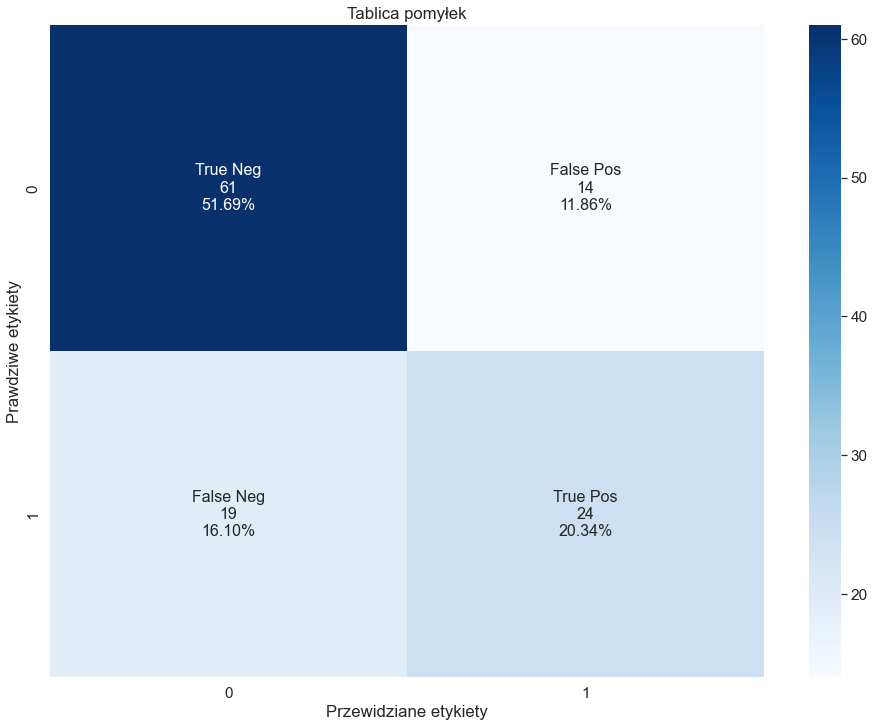

In [149]:
from statistics import mean


shuffled_data = ProcessingData.shuffle(data)
_, validation_data = ProcessingData.split(shuffled_data, 0.7)

zeros = []
ones = []
count0 = 0
count1 = 0
errors0 = 0
errors1 = 0
length0 = 0
length1 = 0

for _, sample in validation_data[validation_data['Outcome'] == 0].iterrows():
    outcome1_test.input['Pregnancies'] = sample['Pregnancies']
    outcome1_test.input['Glucose'] = sample['Glucose']
    # outcome1_test.input['BloodPressure'] = sample['BloodPressure']
    outcome1_test.input['SkinThickness'] = sample['SkinThickness']
    outcome1_test.input['Insulin'] = sample['Insulin']
    outcome1_test.input['BMI'] = sample['BMI']
    outcome1_test.input['DiabetesPedigreeFunction'] = sample['DiabetesPedigreeFunction']
    outcome1_test.input['Age'] = sample['Age']
    try:
        outcome1_test.compute()
        if outcome1_test.output['Outcome1'] < 0.5:
            count0 += 1
        zeros.append(outcome1_test.output['Outcome1'])
        length0 += 1
    except ValueError:
        errors0 += 1

print(f'{round(mean(zeros), 3)=}')

for _, sample in validation_data[validation_data['Outcome'] == 1].iterrows():
    outcome1_test.input['Pregnancies'] = sample['Pregnancies']
    outcome1_test.input['Glucose'] = sample['Glucose']
    # outcome1_test.input['BloodPressure'] = sample['BloodPressure']
    outcome1_test.input['SkinThickness'] = sample['SkinThickness']
    outcome1_test.input['Insulin'] = sample['Insulin']
    outcome1_test.input['BMI'] = sample['BMI']
    outcome1_test.input['DiabetesPedigreeFunction'] = sample['DiabetesPedigreeFunction']
    outcome1_test.input['Age'] = sample['Age']
    try:
        outcome1_test.compute()
        if outcome1_test.output['Outcome1'] >= 0.5:
            count1 += 1
        ones.append(outcome1_test.output['Outcome1'])
        length1 += 1
    except ValueError:
        errors1 += 1

print(f'{round(mean(ones), 3)=}')

print(f'Accuracy for 0: {count0}/{length0}; {count0 / length0 * 100:0.2f}%; {errors0=}')
print(f'Accuracy for 1: {count1}/{length1}; {count1 / length1 * 100:0.2f}%; {errors1=}')
print(f'Accuracy for all: {count0 + count1}/{length0 + length1}; {(count0 + count1) / (length0 + length1) * 100:0.2f}%; errors for all: {errors0 + errors1}')

# Tworzenie tablicy pomyłek
cf_matrix = np.array([[count0, length1 - count1],
                      [length0 - count0, count1]])

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = [f'{value:0.0f}' for value in cf_matrix.flatten()]

group_percentages = [f'{value:.2%}' for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(16,12))
sns.set(font_scale=1.4)
plot = sns.heatmap(cf_matrix, annot=labels, annot_kws={'size':16}, fmt='', cmap='Blues')
plot.set_title('Tablica pomyłek')
plot.set_xlabel('Przewidziane etykiety')
plot.set_ylabel('Prawdziwe etykiety')

In [ ]:
outcome1.view(sim=outcome1_test)

In [ ]:
"""
Z wszystkimi: 80/57/70
Bez bloodpressure: 75/72/74 imo optymalny wybór; obecnie jest z wszystkimi
Bez skinthickness: 80/55/72
Bez diabetespedigreefunction: 78/50/70
Bez bloodpressure i skinthickness: 73/72/72 ale największe do tej pory odchylenie wyników
"""